## **Importing the libraries**

In [31]:
import os
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from google.colab import drive

## **Getting the data**

In [2]:
# Connect to my Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Define the directory paths of the train images and test images
train_data_path = "/content/drive/MyDrive/waste_image_classification/TRAIN"
val_data_path = "/content/drive/MyDrive/waste_image_classification/VAL"
test_data_path = "/content/drive/MyDrive/waste_image_classification/TEST"

In [32]:
# Create an object of the ImageDataGenerator class to help obtain images from the directory paths
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

# Get train images
train_generator = train_datagen.flow_from_directory(train_data_path, batch_size = 32, class_mode = 'binary', target_size = (150,150), seed = 99)

# Get the validation images
val_generator = val_datagen.flow_from_directory(val_data_path, shuffle = False, batch_size = 32, class_mode = 'binary', target_size = (150, 150))

# Get test images
test_generator = test_datagen.flow_from_directory(test_data_path, shuffle = False, batch_size = 32, class_mode = 'binary', target_size = (150, 150))

Found 19998 images belonging to 2 classes.
Found 475 images belonging to 2 classes.
Found 2038 images belonging to 2 classes.


## **Creating a data frame**

In [26]:
training_data_df = pd.DataFrame(data={"file":train_generator.filepaths, "labels": train_generator.labels})

training_data_df['labels'].value_counts()

1    9999
0    9999
Name: labels, dtype: int64

In [27]:
training_data_df.sample()

,file,labels
8198,/content/drive/MyDrive/waste_image_classificat...,0


## **Visualizing the test data**

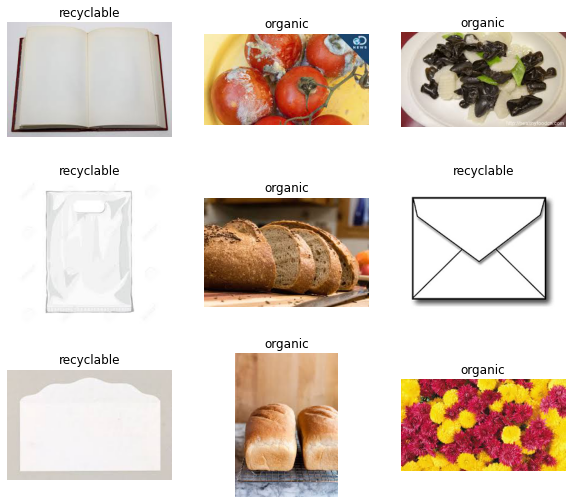

In [28]:
## visualizing some training data
sample_training_data = training_data_df.sample(9)
sample_training_data.reset_index(drop = True, inplace = True)
label_mapping = {0:"organic", 1:"recyclable"}

plt.figure(figsize = (10,9))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(sample_training_data.iloc[i]['file']))
  plt.title(label_mapping[sample_training_data.iloc[i]['labels']])
  plt.axis("off")

## **Training InceptionV3 model**

In [34]:
# Create an InceptionV3 model using the imagenet weights
model = InceptionV3(include_top = False, input_shape = (150, 150, 3), weights = 'imagenet')

In [35]:
# Freeze the learned weights so as to avoid destroying any of the information they contain during future training rounds
for layer in model.layers:
  layer.trainable = False

output = model.layers[-1].output

optimizer = Adam(learning_rate = 0.000001)

# Flatten the convolution output
x = layers.Flatten()(output)
# Add fully connected layer
x = layers.Dense(1024, activation='relu')(x)
# Dropout layer for regularization
x = layers.Dropout(0.2)(x)
# Add a sigmoid layer for final prediction
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(model.input, x)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit(train_generator, validation_data = val_generator, epochs = 1, verbose = 1, callbacks = [earlystop])

625/625 [==============================] - 2988s 5s/step - loss: 0.4515 - accuracy: 0.7971 - val_loss: 0.2896 - val_accuracy: 0.8737


In [39]:
print(history.history)

{'loss': [0.4515284597873688], 'accuracy': [0.7971296906471252], 'val_loss': [0.28960511088371277], 'val_accuracy': [0.8736842274665833]}


## **Testing on the test data**

In [50]:
# Evaluate the model of the test data
model_evaluation = model.evaluate(test_generator)

print(dict(zip(model.metrics_names, model_evaluation)))

64/64 [==============================] - 438s 7s/step - loss: 0.3700 - accuracy: 0.8327
{'loss': 0.3699658513069153, 'accuracy': 0.8326790928840637}


In [54]:
predictions = model.predict(test_generator)

In [56]:
# Show the confusion matrix 
predictions = np.where(predictions > 0.5,1,0)
predictions.reshape((predictions.shape[0],))

cm = confusion_matrix(test_generator.labels, predictions)
cm

array([[1064,  102],
       [ 239,  633]])

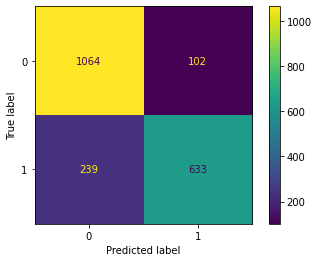

In [57]:
ConfusionMatrixDisplay.from_predictions(test_generator.labels, predictions)

In [60]:
# Show the F1 score
cr = classification_report(test_generator.labels, predictions, labels=[1,0])
print(cr)

              precision    recall  f1-score   support

           1       0.86      0.73      0.79       872
           0       0.82      0.91      0.86      1166

    accuracy                           0.83      2038
   macro avg       0.84      0.82      0.82      2038
weighted avg       0.84      0.83      0.83      2038



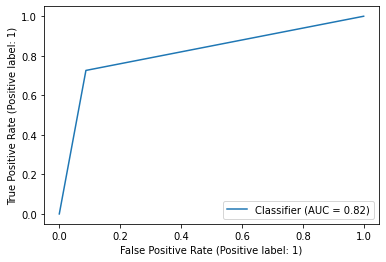

In [61]:
# Show the ROC curve
RocCurveDisplay.from_predictions(test_generator.labels, predictions)

## **Save the trained model**

In [62]:
model.save("/content/drive/MyDrive/waste_image_classification/waste_model.h5", save_format="h5")